## Final Dataset Preparation for Modelling
Given that we have concluded our EDA on the weather dataset, we have concluded that the relevant factors are 'Tavg', 'DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir'. We will now combine these weather features with both our train and test dataset.

From our research on [Culex Lifecycles](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html) and a paper on how the [climate affects the West Nile Virus spread](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/) we have found out that temperature, humidity and rain affects multiple parts of a mosquito's lifecycle.

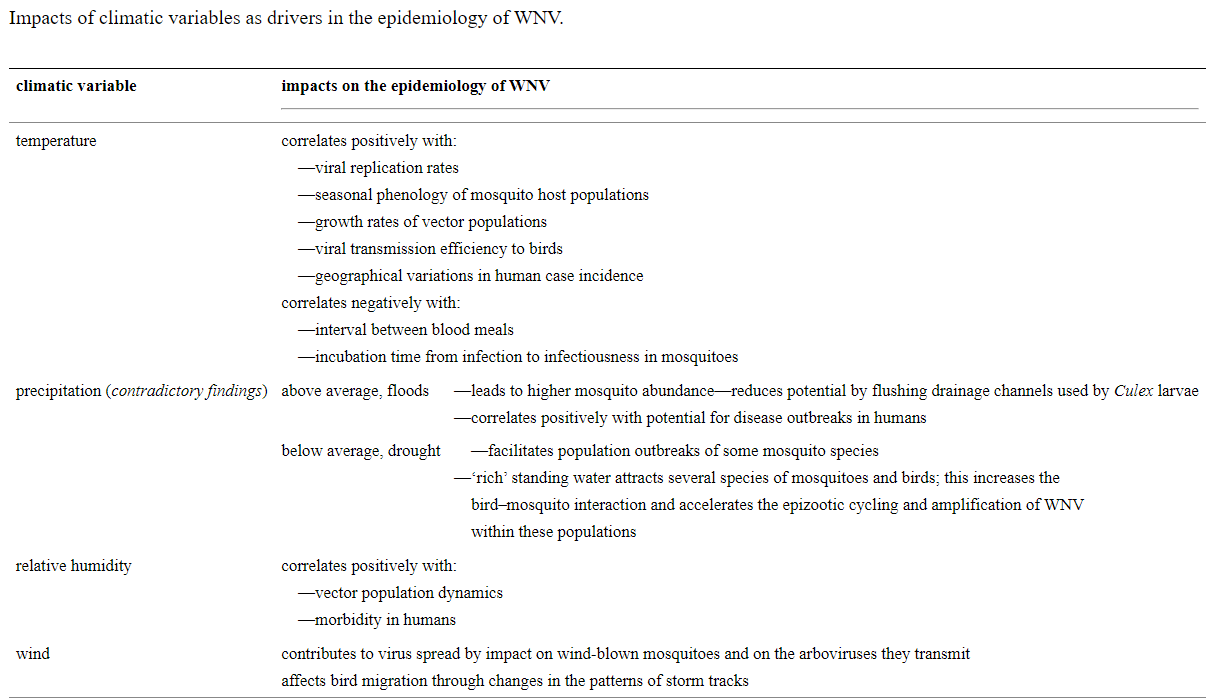

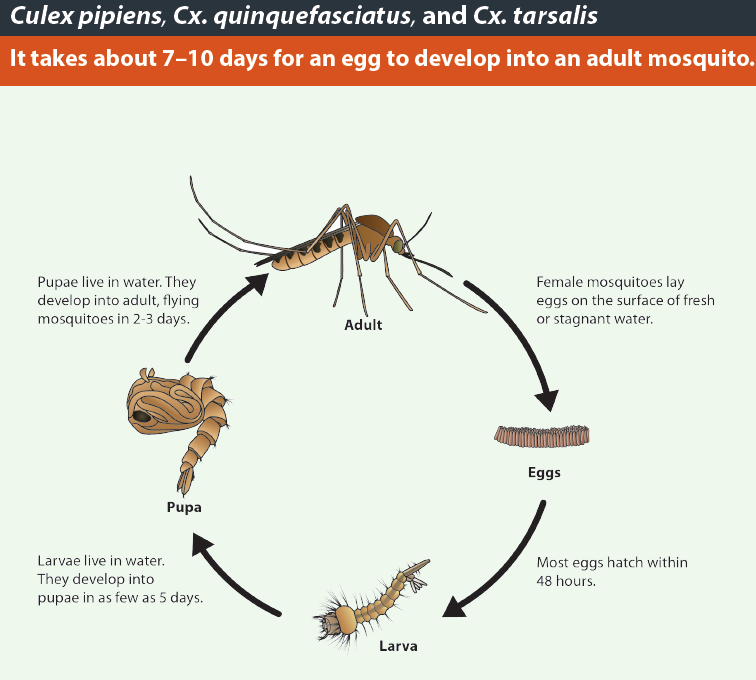

We can see that the mosquito's lifecycle spans from 7-10 days from the eggs being laid, larvae, pupae and then being an adult.

For this reason, we will have to modify the weather data to be backward looking to take into account the events that occurred before the West Nile Virus was detected to see what the weather conditions were like during and before the identification of West Nile Virus. We will be exploring these features below and attempting to build a dataset that contains our train data and matching weather data.

From the data above, wind and air pressure only affects the mosquito at adult stage and these need not be lagged. Other features such as humidity, rain and temperature affect the other stages of a mosquito's life cycle.

In [6]:
# Let's first read in the libraries
import pandas as pd
import requests
import time
import random
import string
import scipy.stats as stats
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# We read in the cleaned datasets
test_clean = pd.read_csv('./data/test_clean.csv')
train_clean = pd.read_csv('./data/train_clean.csv')
weather_clean = pd.read_csv('./data/weather_clean.csv')

In [3]:
# We change the date column to datetime and set it as index
train_clean['Date'] = pd.to_datetime(train_clean['Date'])
train_clean.reset_index(drop=True,inplace=True)
train_clean.set_index('Date',inplace=True)

test_clean['Date'] = pd.to_datetime(test_clean['Date'])
test_clean.reset_index(drop=True,inplace=True)
test_clean.set_index('Date',inplace=True)

weather_clean.drop(axis=1, columns = ['Unnamed: 0'], inplace = True)

weather_clean['Date'] = pd.to_datetime(weather_clean['Date'])
weather_clean.reset_index(drop=True,inplace=True)
weather_clean.set_index('Date',inplace=True)

In [4]:
# We merge the features that do not need to be lagged
train_final = train_clean.merge(weather_clean[['StnPressure', 'ResultSpeed', 'ResultDir']], left_index=True, right_index=True)
test_final = test_clean.merge(weather_clean[['StnPressure', 'ResultSpeed', 'ResultDir']], left_index=True, right_index=True)

We did some experiments on lagging weather features. (DewPoint, Tavg and PrecipTotal).

First, we lagged each day's weather by one day up to 10 days and have each lagged day as a new variable. What we found is that features around the 3 to 5 day mark have the most significance when passed through a simple logistic regression.

Further experiment showed that rolling these features provided better results and as such, we rolled from a range of 2 to 6 days for each feature.

In [7]:
# We create a seperate dfs for weather features we wish to roll
dew = weather_clean[['DewPoint']]
dew['DewPoint_roll2'] = dew['DewPoint'].rolling(window=2).mean()
dew['DewPoint_roll3'] = dew['DewPoint'].rolling(window=3).mean()
dew['DewPoint_roll4'] = dew['DewPoint'].rolling(window=4).mean()
dew['DewPoint_roll5'] = dew['DewPoint'].rolling(window=5).mean()
dew['DewPoint_roll6'] = dew['DewPoint'].rolling(window=6).mean()

temp = weather_clean[['Tavg']]
temp['Tavg_roll2'] = temp['Tavg'].rolling(window=2).mean()
temp['Tavg_roll3'] = temp['Tavg'].rolling(window=3).mean()
temp['Tavg_roll4'] = temp['Tavg'].rolling(window=4).mean()
temp['Tavg_roll5'] = temp['Tavg'].rolling(window=5).mean()
temp['Tavg_roll6'] = temp['Tavg'].rolling(window=6).mean()

precip = weather_clean[['PrecipTotal']]
precip['PrecipTotal_roll2'] = precip['PrecipTotal'].rolling(window=2).mean()
precip['PrecipTotal_roll3'] = precip['PrecipTotal'].rolling(window=3).mean()
precip['PrecipTotal_roll4'] = precip['PrecipTotal'].rolling(window=4).mean()
precip['PrecipTotal_roll5'] = precip['PrecipTotal'].rolling(window=5).mean()
precip['PrecipTotal_roll6'] = precip['PrecipTotal'].rolling(window=6).mean()

In [8]:
# We then merge
train_final = train_final.merge(dew, left_index=True, right_index=True)
test_final = test_final.merge(dew, left_index=True, right_index=True)

train_final = train_final.merge(temp, left_index=True, right_index=True)
test_final = test_final.merge(temp, left_index=True, right_index=True)

train_final = train_final.merge(precip, left_index=True, right_index=True)
test_final = test_final.merge(precip, left_index=True, right_index=True)

In [9]:
# We save these files
train_final.to_csv('train_final.csv', index=False)
test_final.to_csv('test_final.csv', index=False)

Now that we have a clean dataset of the features we want to model on, we move on to define our X and y. We drop columns that have been dummified and columns that have no relevance to our modelling.

In [10]:
# We define X train, X test and y. We drop features that have no relevance to Wnv
X_train = train_final.drop(columns = ['Address','Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy',
'tot_mosquitos','WnvPresent','month_year','year', 'month', 'day'])
y_train = train_final['WnvPresent']
X_test = test_final.drop(columns = ['Address',
'Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy','Id','month_year', 'year', 'month', 'day'])

# Scale columns that need to be scaled

ss = StandardScaler()

scale_list = ['StnPressure', 'ResultSpeed','ResultDir',
              'DewPoint', 'DewPoint_roll2','DewPoint_roll3','DewPoint_roll4','DewPoint_roll5', 'DewPoint_roll6',
             'Tavg', 'Tavg_roll2','Tavg_roll3','Tavg_roll4','Tavg_roll5', 'Tavg_roll6',
             'PrecipTotal', 'PrecipTotal_roll2','PrecipTotal_roll3','PrecipTotal_roll4','PrecipTotal_roll5','PrecipTotal_roll6']

X_train[scale_list] = ss.fit_transform(X_train[scale_list])

X_test[scale_list] = ss.transform(X_test[scale_list])

# SMOTE
sm = SMOTE(sampling_strategy = {1: 8000}, random_state = 42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

# Dataframes now are Xsm_train, ysm_train and X_test

Given that we have many features, we will use a Lasso regression to identify if we can drop any features.

In [12]:
# We then use Lasso to pull out irrelevant features
lassocv = LassoCV(n_alphas=200)
lassocv.fit(Xsm_train, ysm_train)

LassoCV(n_alphas=200)

In [13]:
# We then look at the coefficients of lasso
for i, name in enumerate(Xsm_train.columns):
    print(name, lassocv.coef_[i])

pipiens/restuans -0.24137377075514768
restuans -0.2993012425328969
pipiens -0.2241462556293273
salinarius -0.350237915525061
territans -0.3500666135028787
tarsalis -0.0
erraticus -0.0
unspecified 0.0
6 -0.13298184252080048
7 -0.11149315602891689
8 -0.01683530114905912
9 -0.055796556887096525
10 -0.10242827604383625
T048 -0.7601324686747157
T091 -0.7784503083682625
T049 -0.8093097059393907
T153 -0.780118361202824
T045 -0.6686291396212304
T094 -0.7909537730500991
T050 -0.7669770846081213
T054 -0.7528275645703207
T086 -0.6634589163988226
T096 -0.6713084089411937
T046 -0.8246432552068188
T002 -0.7068448947089471
T007 -0.7698303502002717
T143 -0.5146692272510464
T148 -0.7908337383829119
T015 -0.6773868507294429
T159 -0.7473811311240061
T129 -0.7630239315256252
T092 -0.8083444840460066
T033 -0.7789770777287068
T149 -0.7029487846339024
T150 -0.7534737438496746
T154 -0.6746016253927429
T152 -0.7949700898946217
T147 -0.6879471373805711
T158 -0.78646132935875
T011 -0.703566723116418
T218 -0.7756

We see that there are some species and trap dummies that have coefficients of 0. We will be dropping these as well.

In [14]:

# We then drop the features that have coefficient of 0 and redefine X train, X test
X_train = train_final.drop(columns = ['Address','Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy',
'tot_mosquitos','WnvPresent','month_year','year', 'month', 'day',
                                     'tarsalis', 'erraticus', 'unspecified',
                                     'T040', 'T200B', 'T234', 'T090A', 'T090C',
                                     'T090B', 'T218C', 'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 'T065A'  ])
y_train = train_final['WnvPresent']
X_test = test_final.drop(columns = ['Address',
'Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy','Id','month_year', 'year', 'month', 'day',
                                   'tarsalis', 'erraticus', 'unspecified',
                                   'T040', 'T200B', 'T234', 'T090A', 'T090C',
                                     'T090B', 'T218C', 'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 'T065A'])

# Scale columns that need to be scaled

ss = StandardScaler()

scale_list = ['StnPressure', 'ResultSpeed','ResultDir',
              'DewPoint', 'DewPoint_roll2','DewPoint_roll3','DewPoint_roll4','DewPoint_roll5', 'DewPoint_roll6',
             'Tavg', 'Tavg_roll2','Tavg_roll3','Tavg_roll4','Tavg_roll5', 'Tavg_roll6',
             'PrecipTotal', 'PrecipTotal_roll2','PrecipTotal_roll3','PrecipTotal_roll4','PrecipTotal_roll5','PrecipTotal_roll6']

X_train[scale_list] = ss.fit_transform(X_train[scale_list])

X_test[scale_list] = ss.transform(X_test[scale_list])

# SMOTE
sm = SMOTE(sampling_strategy = {1: 8000}, random_state = 42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

# Dataframes now are Xsm_train, ysm_train and X_test

In [15]:
# Sample with a logistic regression
lr = LogisticRegression()
lr.fit(Xsm_train, ysm_train)
lr.score(Xsm_train, ysm_train)

0.9674363895251656

In [16]:
# Prepare for kaggle
predict_probs = lr.predict_proba(X_test).tolist()

pred = []
for i in range(0, len(predict_probs)):
               pred.append(predict_probs[i][1])
        
sample_submission_lr = pd.DataFrame()
sample_submission_lr['Id'] = test_final['Id']
sample_submission_lr['WnvPresent'] = pred
sample_submission_lr.reset_index(drop=True, inplace=True)
sample_submission_lr.to_csv('./submissions/sample_submission_lr.csv', index=False)

The Kaggle submission score is **0.72682** which gives us confidence before moving on to fine tuning and testing other models.